In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Veri Seti Hakkında

İncelenen grup, deneme için rastgele seçilen, her biri 70 element olan Kama, Rosa ve Kanada olmak üzere üç farklı buğday çeşidine ait tanelerden oluşuyordu. Yumuşak bir X-ray tekniği kullanılarak iç çekirdek yapısının yüksek kalitede görselleştirilmesi tespit edildi. Tahribatsızdır ve tarama mikroskobu veya lazer teknolojisi gibi diğer daha karmaşık görüntüleme tekniklerinden çok daha ucuzdur. Görüntüler 13x18 cm X-ray KODAK plakalarına kaydedildi. Lublin'deki Polonya Bilimler Akademisi'nin Agrofizik Enstitüsü'nde keşfedilen deneysel alanlardan elde edilen kombine hasat edilmiş buğday taneleri kullanılarak çalışmalar yapıldı.

Özellik Bilgileri:

Verileri oluşturmak için, buğday tanelerinin yedi geometrik parametresi ölçüldü:
- alan
- çevre
- kompaktlık
- tane uzunluğu
- tane genişliği
- asimetri katsayısı
- çekirdek oluğu uzunluğu

Bu parametrelerin tümü gerçek değerli sürekli idi.


In [2]:
df=pd.read_csv('seeds_dataset.txt',sep='\t',names=['area','perimeter','compactness','length of kernel','width of kernel',\
                                           'asymmetry coefficient','length of kernel groove','seed type'])

In [3]:
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,seed type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [4]:
df.info()
# Veri seti ile ilgili ön bilgiler.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   area                     210 non-null    float64
 1   perimeter                210 non-null    float64
 2   compactness              210 non-null    float64
 3   length of kernel         210 non-null    float64
 4   width of kernel          210 non-null    float64
 5   asymmetry coefficient    210 non-null    float64
 6   length of kernel groove  210 non-null    float64
 7   seed type                210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [5]:
df.shape
# veri setinin boyutu

(210, 8)

In [6]:
# Veri setindeki her bir özelliğin istatistiksel dağılımları
df.describe().T

,count,mean,std,min,25%,50%,75%,max
area,210.0,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
perimeter,210.0,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
compactness,210.0,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
length of kernel,210.0,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
width of kernel,210.0,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
asymmetry coefficient,210.0,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
length of kernel groove,210.0,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500
seed type,210.0,2.000000,0.818448,1.0000,1.00000,2.00000,3.000000,3.0000


In [7]:
# Veri setindeki her bir özelliğin varyansları.
df.var()

area                       8.466351
perimeter                  1.705528
compactness                0.000558
length of kernel           0.196305
width of kernel            0.142668
asymmetry coefficient      2.260684
length of kernel groove    0.241553
seed type                  0.669856
dtype: float64

In [8]:
# Bağımlı değişkenin sınıf dağılımlarını inceleyelim.
df["seed type"].value_counts()

1    70
2    70
3    70
Name: seed type, dtype: int64

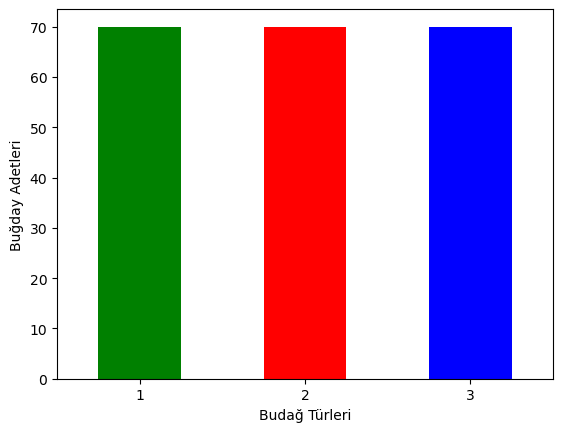

In [9]:
df['seed type'].value_counts().plot.bar(color=['green','red','blue'])
plt.xlabel('Budağ Türleri')
plt.ylabel('Buğday Adetleri')
plt.xticks(rotation=0)
plt.show()

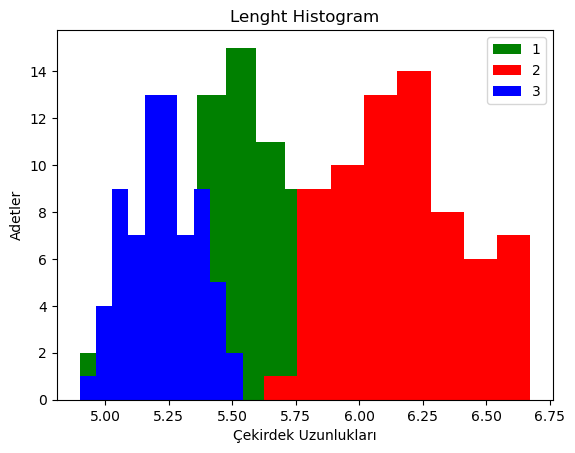

In [10]:
# buğdayların çekirdek uzunlukları ile buğday türleri arasındaki bağlantı
plt.hist(df[df['seed type']==1]['length of kernel'],label="1",color='green')
plt.hist(df[df['seed type']==2]['length of kernel'],label="2",color='red')
plt.hist(df[df['seed type']==3]['length of kernel'],label="3",color='blue')
plt.title("Lenght Histogram")
plt.xlabel('Çekirdek Uzunlukları')
plt.ylabel('Adetler')
plt.legend()
plt.show()

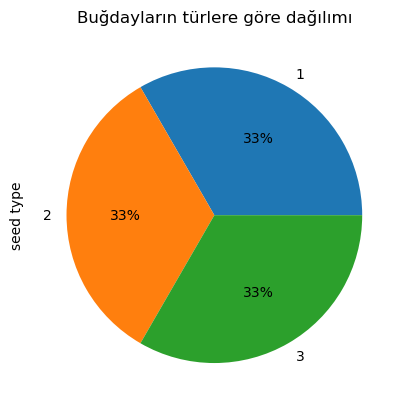

In [11]:
is_spam=pd.value_counts(df['seed type'],sort=True)
is_spam.plot(kind="pie",labels=["1", "2","3"],autopct="%1.0f%%")
plt.title("Buğdayların türlere göre dağılımı")
plt.show()

## PCA 

PCA özellike kümelede değişkenler arasındaki mesafeyi azaltmak ve normal bir aralığa getirme (normalization) bunun dışında ise n boyutlu bir veri setini m boyuta (m<n) indirgeme de kullanılan önemli bir işlemdir.

PCA sayesinde özelliklerin dağılımı ve kümelenmesi çok daha güzel bir şekilde gerçekleşecektir.

In [12]:
X=df.iloc[:,:-1]

In [13]:
pca = PCA(n_components=2)

In [14]:
pca_X=pca.fit_transform(X.values)

In [15]:
pca_df=pd.DataFrame(data = pca_X, columns = range(1,3))

In [16]:
pca_df = pd.concat([pca_df, df['seed type']], axis = 1)

## Bölümleyici Temelli KMeans

Bölüm tabanlı kümeleme yöntemleri, verilen nesneleri, m boyutlu bir düzlemde rastgele veya belirli bazı nesnelerden uzaklıklarını ölçerek kümeleme yapar. Bu nedenle, bu yöntemler aynı zamanda mesafeye dayalı yöntemler olarak da bilinmektedir.

- Homojenlik (Homogeneity): Her küme yalnızca bir sınıfın üyelerini içermektedir. 0 ve 1 arasında değerler alır ve 1'e yakın değerler iyi sayılmaktadır.
- Tamlık (Completeness): Belirli bir sınıfın bütün üyeleri aynı kümeye atanır. Daha sonra 0 ve 1 arasında değerler alır ve 1'e yakın değerler iyi sayılmaktadır.
- V-İndeksi (V-measure): Tamlık ve homojenlik değerlerinin harmonik ortalaması ile hesaplanmaktadır.
- Rand indeksi (Adjusted Rand-Index): Kümedeki verinin değerini hesaplarken o veriyi aynı kümede olan diğer verilerle karşılaştırır. 0 ve 1 arasında değerler alır ve 1'e yakın değerler iyi sayılmaktadır.
- Silhouette İndeksi (Silhouette Coefficient): Kümelenen verilerin, bulunduğu kümedeki uygunluğunu bulmak için kullanılmaktadır. -1 ve 1 arasında değerler alır ve 1'e yakın değerler iyi sayılmaktadır.
- Silhouette Score: Genellikle etiketsiz kümelede kullanılır. İki küme arasındaki mesafe bilgisini döndürür.

In [17]:
# 3 farklı bağımlı değişkene sahip olduğumuz için 3'lü kümeleme yapacağız.
num_clusters = 3
km = KMeans(num_clusters)
fitted=km.fit_predict(pca_X)
clusters = km.labels_.tolist()

In [18]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pca_df['seed type'], km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(pca_df['seed type'], km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(pca_df['seed type'], km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(pca_df['seed type'], km.labels_))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(pca_X, km.labels_))
print("Silhouette Score: %0.3f"%silhouette_score(pca_X, labels=fitted))

Homogeneity: 0.693
Completeness: 0.696
V-measure: 0.695
Adjusted Rand-Index: 0.717
Silhouette Coefficient: 0.480
Silhouette Score: 0.480


In [19]:
pca_X[:, 0]

array([ 0.66344838,  0.31566651, -0.6604993 , -1.0552759 ,  1.61999921,
       -0.47693801, -0.18483472, -0.78062962,  2.2821081 ,  1.97854147,
        0.36912295, -0.7110212 , -1.21370535, -1.16908541, -1.19272176,
       -0.50817121, -1.37469698,  1.05726438, -0.1509611 , -2.46241293,
       -0.6313321 , -0.68969866,  1.40769072, -2.84267672,  0.43326822,
        1.81289158, -2.02131332, -2.19571862, -0.74446884, -1.5035048 ,
       -1.5207532 ,  0.76119026, -0.76773843, -0.82396593,  0.4395424 ,
        1.52205298,  1.65240525,  2.47674445,  0.01157507, -1.11443822,
       -1.3716017 , -1.36349513, -1.88302954,  0.62956057,  0.28441212,
       -0.96004475,  0.81896462,  0.1966213 ,  0.01532761,  0.25423517,
       -0.50538453,  0.71197309, -0.35582938, -0.56685633,  0.01809689,
        0.47842486, -0.37546464,  0.28388332,  0.76942973, -2.77110124,
       -3.8034482 , -4.00534905, -2.87823982, -1.87406423, -2.0508933 ,
       -2.16820614, -0.2596738 , -0.70708443, -0.23711422, -2.28

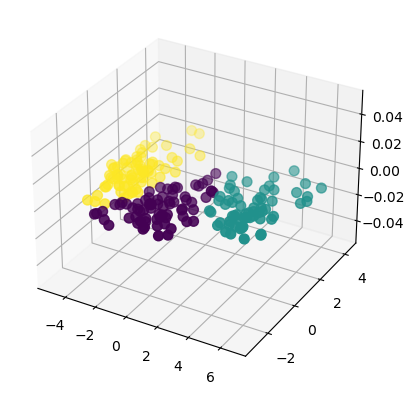

In [19]:
ax = plt.axes(projection ="3d")
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=fitted, s=50, cmap='viridis');
plt.show()

## Bölümleyici Temelli GaussianMixture

In [20]:
from sklearn.mixture import GaussianMixture

In [21]:
gmm = GaussianMixture(n_components=3)
labels = gmm.fit_predict(pca_X)

In [22]:
print("Silhouette Score: %0.3f"%silhouette_score(pca_X, labels=labels))

Silhouette Score: 0.472


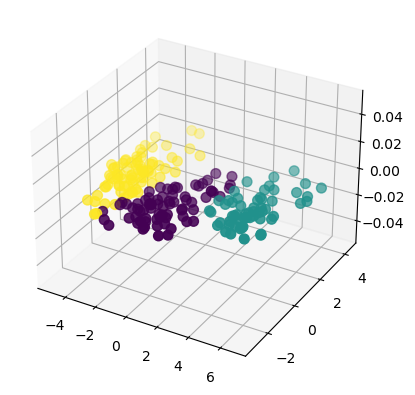

In [23]:
ax = plt.axes(projection ="3d")
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=labels, s=50, cmap='viridis');
plt.show()

## Yoğunluk Temelli DBSCAN

Yoğunluğa dayalı kümeleme yöntemlerinde, veri noktalarının mesafesini göz önünde bulundurmak yerine bir mahalle kümeleri oluşturduğu düşünülmektedir. Komşuluk, verilen verilerden bir küme oluşturmak için ilgilenilen bir bölgede (tipik olarak başka bir veri noktası) bulunması gereken buradaki veri noktalarının sayısını ifade eder.

In [24]:
# DBSCAN
from sklearn.cluster import DBSCAN

In [25]:
db = DBSCAN(min_samples=3,algorithm='ball_tree').fit(pca_X)
label=db.fit_predict(pca_X)
labels = db.labels_

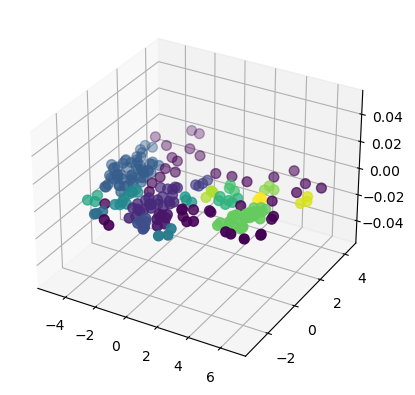

In [26]:
ax = plt.axes(projection ="3d")
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=label, s=50, cmap='viridis');
plt.show()

In [27]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pca_df['seed type'], db.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(pca_df['seed type'], db.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(pca_df['seed type'], db.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(pca_df['seed type'], db.labels_))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(pca_X, db.labels_))
print("Silhouette Score: %0.3f"%silhouette_score(pca_X, labels=label))

Homogeneity: 0.707
Completeness: 0.339
V-measure: 0.458
Adjusted Rand-Index: 0.336
Silhouette Coefficient: 0.162
Silhouette Score: 0.162


## Sonuç

V-measure kriteri göz önüne alındığında ve grafiklerden de görüleceği üzere elimizdeki verileri en iyi şekilde ayrıştıran, kümeleyen algoritma KMeans algoritması olmuştur. 

Bu veri seti için mesafeye dayalı yöntem verileri en iyi şekilde ayrıştırmıştır.